# 1. 데이터 불러오기
- y값: g191a297 (A52. <취업자 공통> <이직 준비 관련> 이직준비를 하고 있는지 여부)

In [ ]:
conda install -c conda-forge imbalanced-learn

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/osx-arm64/current_repodata.json HTTP/1.1" 304 0
\ DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): conda.anaconda.org:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): conda.anaconda.org:443
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/osx-arm64/current_repodata.json HTTP/1.1" 304 0
| DEBUG:urllib3.connectionpool:https://conda.anaconda.org:443 "GET /conda-forge/noarch

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import re
import semopy
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from semopy import Model, report
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pydot
from IPython.display import Image, display

In [ ]:
# 데이터 불러오기
GP19 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/GP19__2020.csv" , encoding='EUC-KR', low_memory=False)
GP18 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/GP18__2019.csv" , encoding='EUC-KR', low_memory=False)
GP17 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/GP17__2018.csv" , encoding='EUC-KR', low_memory=False)
GP16 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/GP16__2017.csv" , encoding='EUC-KR', low_memory=False)
GP15 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/GP15__2016.csv" , encoding='EUC-KR', low_memory=False)
GP14 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/GP14__2015.csv" , encoding='EUC-KR', low_memory=False)
GP13 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/GP13__2014.csv" , encoding='EUC-KR', low_memory=False)
GP12 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/GP12__2013.csv" , encoding='EUC-KR', low_memory=False)
GP11 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/GP11__2012.csv" , encoding='EUC-KR', low_memory=False)
GP10 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/GP10__2011.csv" , encoding='EUC-KR', low_memory=False)

In [ ]:
# 연도 컬럼 생성
GP19['Year'] = 'GP19'
GP18['Year'] = 'GP18'
GP17['Year'] = 'GP17'
GP16['Year'] = 'GP16'
GP15['Year'] = 'GP15'
GP14['Year'] = 'GP14'
GP13['Year'] = 'GP13'
GP12['Year'] = 'GP12'
GP11['Year'] = 'GP11'
GP10['Year'] = 'GP10'

In [ ]:
def remove_digits(col_name):
    if len(col_name) > 4 and col_name[1:4].isdigit():
        return col_name[0] + col_name[4:]
    return col_name

dfs = [GP19, GP18, GP17, GP16, GP15, GP14, GP13, GP12, GP11, GP10]

dfs_dict = {}

for df in dfs:
    df.columns = [remove_digits(col) for col in df.columns]

GP19.columns = [remove_digits(col) for col in GP19.columns]

filtered_dfs = [GP19]
for df in dfs[1:]:
    common_columns = GP19.columns.intersection(df.columns)
    filtered_dfs.append(df[common_columns])

In [ ]:
# 데이터 합치기
combined_df = pd.concat(filtered_dfs, ignore_index=True)

In [ ]:
def add_digits(col_name):
    return col_name[0] + '191' + col_name[1:]
combined_df.columns = [add_digits(col) for col in combined_df.columns]

In [ ]:
# 데이터프레임 저장
combined_df.to_csv("/content/drive/MyDrive/Colab Notebooks/data/Combined_GP.csv", index=False, encoding='EUC-KR')

# 2. 로우 필터링
- D1이 1이고 D3(g191d006): 일자리가 아르바이트였는지 여부 (1알바 2알바아님)
  - 대학 졸업 후 첫 일자리가 아르바이트가 아님. (d3가 2)
  - 대학 졸업 후 첫 일자리가 아르바이트이지만, 그 이후에(중간일자리, 현재 일자리) 직장 다님. (d3가 1이지만, e3(경험일자리1이 알바였는지 여부, g191e007)가 2 or e29(경험일자리2, g191e082)가 2 or e55(경험일자리3, g191e157)이 2 or a3(현재 아르바이트 여부, g191a003)가 2)
- D9(g191d023): 첫 직장 종사상 지위 (1상용근로자 2임시근로자 3일용근로자 4고용원이 있는 자영업자 5고용원이 없는 자영업자 6무급가족종사자)
  - 1번
  - 1번 아니면 모두 첫 직장 모두 null 처리(g191d001 ~ g191d249)
- E9(g191e021): 경험일자리1 종사상 지위
  - 1번
  - 1번 아니면 모두 경험일자리1 모두 null 처리(g191e001 ~ g191e077)
- E35(g191e096): 경험일자리2 종사상 지위
  - 1번
  - 1번 아니면 모두 경험일자리2 모두 null 처리(g191e078 ~ g191e152)
- E61(g191e171): 경험일자리3 종사상 지위
  - 1번
  - 1번 아니면 모두 경험일자리2 모두 null 처리(g191e153 ~ g191e221)

In [ ]:
# combined df 불러오기
combined_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/Combined_GP.csv" , encoding='EUC-KR', low_memory=False)

In [ ]:
combined_df['Y191ear'].unique()

In [ ]:
# d 관련 컬럼
lst_dcolumns = []
for col in combined_df.columns:
  if 'g191d' in col:
    lst_dcolumns.append(col)

In [ ]:
# e 관련 컬럼
lst_ecolumns = []
for col in combined_df.columns:
  if 'g191e' in col:
    lst_ecolumns.append(col)

In [ ]:
combined_df['g191d023'][combined_df['g191d023']!=1]

In [ ]:
# 각 조건에 따라 특정 열을 None으로 설정하는 함수 정의
def set_columns_to_none(df, condition, columns):
    df.loc[condition, columns] = None

# 조건에 따라 특정 열을 None으로 설정
set_columns_to_none(combined_df, combined_df['g191d023'] != 1, lst_dcolumns)
set_columns_to_none(combined_df, combined_df['g191e021'] != 1, lst_ecolumns[:71])
set_columns_to_none(combined_df, combined_df['g191e096'] != 1, lst_ecolumns[71:136])
set_columns_to_none(combined_df, combined_df['g191e171'] != 1, lst_ecolumns[136:])

In [ ]:
# row 필터링
filtered_df = combined_df[(combined_df['g191d001'] == 1) & ((combined_df['g191d006'] == 2) | ((combined_df['g191d006'] == 1) & ((combined_df['g191e007'] == 2) | (combined_df['g191e082'] == 2) | (combined_df['g191e157'] == 2) | (combined_df['g191a003'] == 2))))]

In [ ]:
filtered_df

In [ ]:
# 필터링된 데이터 저장 (최종 데이터셋)
filtered_df.to_csv("/content/drive/MyDrive/Colab Notebooks/data/filtered_df.csv", index=False, encoding='EUC-KR')

# 3. 전처리

In [ ]:
filtered_df = pd.read_csv("data/filtered_df.csv" , encoding='EUC-KR', low_memory=False)
filtered_df


In [ ]:
# 직업 개인 컬럼
job_personal_df = filtered_df[['g191d032','g191d052','g191d255','g191d053','g191d057','g191d059','g191d060','g191d109',
                'g191d108','g191d113','g191d114','g191d115','g191d110','g191d111','g191d112','g191d150',
                'g191d144','g191d145','g191d146','g191d151','g191d147','g191d148','g191d153','g191d245',
                'g191d248','g191d249','g191e028','g191e064','g191e063','g191e068','g191e069','g191e070',
                'g191e065','g191e066','g191e067','g191e077','g191e103','g191e139','g191e138','g191e143',
                'g191e144','g191e145','g191e140','g191e141','g191e142','g191e152','g191e178','g191e208',
                'g191e207','g191e213','g191e212','g191e214','g191e209','g191e210','g191e211','g191e221',
                'g191j021','g191k042','g191k051','g191k052','g191k053','g191k055','g191k056','g191k057',
                'g191k043','g191k044','g191k045','g191k046','g191k047','g191k048','g191k049','g191k050']]

# 개인환경 컬럼
env_personal_df = filtered_df[['g191e002', 'g191e076', 'g191e075', 'g191e151', 'g191e150',
       'g191e220', 'g191e219', 'g191f021', 'g191f020', 'g191f025',
       'g191f027', 'g191f029', 'g191f071', 'g191f072', 'g191f073',
       'g191f074', 'g191f086', 'g191f099', 'g191f116', 'g191f120',
       'g191f108', 'g191f112', 'g191f104', 'g191f133', 'g191f136',
       'g191f130', 'g191f010', 'g191h002', 'g191h001', 'g191i001',
       'g191j001', 'g191j012', 'g191j013', 'g191j014', 'g191m001',
       'g191m002', 'g191p001', 'g191p035', 'g191p036', 'g191p007',
       'g191p009', 'g191p008', 'g191q001', 'g191q015', 'g191q016',
       'g191q017', 'g191q018', 'g191q019', 'g191q020', 'g191q021',
       'g191q022', 'g191q023', 'g191r002', 'g191r015', 'g191r017',
       'g191r019', 'g191r024', 'g191r025', 'g191r026', 'g191r023',
       'g191r029']]

# 만족도 컬럼
satisfaction_df = filtered_df[[
    'g191d116', 'g191d117', 'g191d118', 'g191d119', 'g191d120',
    'g191d121', 'g191d122', 'g191d123', 'g191d124', 'g191d125',
    'g191d126', 'g191d127', 'g191d128', 'g191d129', 'g191d130',
    'g191d131', 'g191d132', 'g191d133', 'g191e071', 'g191e072',
    'g191e073', 'g191e074', 'g191e146', 'g191e147', 'g191e148',
    'g191e149', 'g191e215', 'g191e216', 'g191e217', 'g191e218'
]]

# 직업 특성 컬럼
job_df = filtered_df[[
    'g191d016', 'g191d017', 'g191d018', 'g191d019', 'g191d020',
    'g191d022', 'g191d041', 'g191d042', 'g191d046',
    'g191d048', 'g191d049', 'g191d051', 'g191d254', 'g191d106',
    'g191d152', 'g191e014', 'g191e015', 'g191e016',
    'g191e017', 'g191e018', 'g191e019', 'g191e020', 'g191e061',
    'g191e062', 'g191e089', 'g191e090', 'g191e091', 'g191e092',
    'g191e093', 'g191e094', 'g191e095', 'g191e136', 'g191e137',
    'g191e164', 'g191e165', 'g191e166', 'g191e167', 'g191e168',
    'g191e169', 'g191e170', 'g191e205', 'g191e206'
]]

## 3-1. 전처리 - 결측치 20% 이상 컬럼 드랍

- 개인환경
  - 컬럼 수: 30 > 12
  - 'g191f020', 'g191f071', 'g191f072', 'g191f073', 'g191f074', 'g191f010',
       'g191h001', 'g191i001', 'g191j001', 'g191m001', 'g191p001', 'g191p035'
- 직장개인
  - 16 > 25
  - 'g191d052', 'g191d109', 'g191d108', 'g191d110', 'g191d111', 'g191d112',
       'g191d144', 'g191d145', 'g191d146', 'g191d147', 'g191d148', 'g191d245',
       'g191d249', 'g191j021', 'g191k042', 'g191k053', 'g191k055', 'g191k043',
       'g191k044', 'g191k045', 'g191k046', 'g191k047', 'g191k048', 'g191k049',
       'g191k050'
- 만족도
  - 18 > 14
  - 'g191d116', 'g191d117', 'g191d119', 'g191d120', 'g191d121', 'g191d122',
       'g191d123', 'g191d124', 'g191d125', 'g191d126', 'g191d130', 'g191d131',
       'g191d132', 'g191d133'
- 직장
  - 16 > 13
  - 'g191d016', 'g191d017', 'g191d018', 'g191d020', 'g191d022', 'g191d041',
       'g191d042', 'g191d048', 'g191d049', 'g191d051', 'g191d106', 'g191d107',
       'g191d152'

In [ ]:
# 결측치 20% 이상이면 컬럼 드랍

# 직장 개인 특성
missing_percent = job_personal_df.isnull().mean()
columns_to_drop = missing_percent[missing_percent >= 0.2].index
job_personal_df = job_personal_df.drop(columns=columns_to_drop)

# 개인환경
missing_percent = env_personal_df.isnull().mean()
columns_to_drop = missing_percent[missing_percent >= 0.2].index
env_personal_df = env_personal_df.drop(columns=columns_to_drop)

# 만족도
missing_percent = satisfaction_df.isnull().mean()
columns_to_drop = missing_percent[missing_percent >= 0.2].index
satisfaction_df = satisfaction_df.drop(columns=columns_to_drop)

# 직업 특성
missing_percent = job_df.isnull().mean()
columns_to_drop = missing_percent[missing_percent >= 0.2].index
job_df = job_df.drop(columns=columns_to_drop)

## 3-2. 전처리(직업 개인)

 - g191d109, g191d111, g191d112, g191j021:결측치 평균값
 -  나머지 컬럼 1,0 처리
 -  g191d249
     - 1: 기타및무응답 [-3,-1,14]
     - 2: 계약및조직변화 [1,2,3]
     - 3: 직장내문제 [4,5,6,10]
     - 4: 개인적이유및전환 [7,8,9,11,12,13]
 -  'g191k042', 'g191k053', 'g191k055', 'g191k043', 'g191k044', 'g191k045', 'g191k046', 'g191k047', 'g191k048', 'g191k049', 'g191k050' : 중요도
    - nan값은 1처리

g191d108: 초과근로시간  -> 여부만 따지기

In [ ]:
# g191d108 -->  1, 0 처리
job_personal_df['g191d108'] = job_personal_df['g191d108'].apply(lambda x: 1 if x == 1 else 0).astype('category')

In [ ]:
job_personal_df['g191d112'].unique()

In [ ]:
job_personal_df['g191j021'].unique()

In [ ]:
# 연도 컬럼 추가
job_personal_df['Y191ear'] = filtered_df['Y191ear']

In [ ]:
# 월평균 휴일 근로 -----------------
notwork_days = job_personal_df['g191d109'][job_personal_df['g191d109']!=-1].mean()
job_personal_df['g191d109'][job_personal_df['g191d109']==-1] = notwork_days

job_personal_df['g191d109'].fillna(job_personal_df['g191d109'].mean(), inplace=True)

# ----------------------------------
year_list = sorted(filtered_df['Y191ear'].unique())  # ['GP10', 'GP11', 'GP12', 'GP13', 'GP14', 'GP15', 'GP16', 'GP17', 'GP19']

min_wage_list = [4110, 4320, 4580, 4860, 5210, 5580, 6030, 6470, 7530, 8350]

# 월근로소득(만원) (최저임금의 몇 배인지) -------------------
for year in year_list:
    year_filtered_df = job_personal_df[job_personal_df['Y191ear'] == year]

    last_digits = int(year[-1]) # Y191ear의 마지막 글자 예를 들어 'GP10' 이면 -> '0' 을 수치형으로 만듦
    min_wage = min_wage_list[last_digits]# 최저임금
    # 시간당 최저임금의 몇 배인지로 계산
    year_filtered_df['g191d112'] = year_filtered_df['g191d112'][
        (year_filtered_df['g191d112'] != 0) & (year_filtered_df['g191d112'] != -1)
    ] * 10000 / 209 / min_wage
    # 평균값
    avg_month_salary = year_filtered_df['g191d112'][
        (year_filtered_df['g191d112'] != 0) & (year_filtered_df['g191d112'] != -1)
    ].mean()
    # 결측치 평균값으로 채우기
    year_filtered_df['g191d112'] = year_filtered_df['g191d112'].replace(0, avg_month_salary)
    year_filtered_df['g191d112'] = year_filtered_df['g191d112'].replace(-1, avg_month_salary)
    year_filtered_df['g191d112'].fillna(avg_month_salary, inplace=True)

    job_personal_df.loc[year_filtered_df.index, 'g191d112'] = year_filtered_df['g191d112']

# 희망연봉(만원) (최저임금의 몇 배인지) ---------------------
for year in year_list:

    year_filtered_df = job_personal_df[job_personal_df['Y191ear'] == year]

    last_digits = int(year[-1])
    min_wage = min_wage_list[last_digits] # 최저임금
    # 시간당 최저임금의 몇 배인지로 계산
    year_filtered_df['g191j021'] = year_filtered_df['g191j021'][
        (year_filtered_df['g191j021'] != 0) & (year_filtered_df['g191j021'] != -1)
    ] * 10000 / (209 * 12) / min_wage

    # 평균값
    avg_expected_salary = year_filtered_df['g191j021'][
        (year_filtered_df['g191j021'] != 0) & (year_filtered_df['g191j021'] != -1)
    ].mean()
    # 결측치 평균값으로 채우기
    year_filtered_df['g191j021'] = year_filtered_df['g191j021'].replace(0, avg_expected_salary)
    year_filtered_df['g191j021'] = year_filtered_df['g191j021'].replace(-1, avg_expected_salary)
    year_filtered_df['g191j021'].fillna(avg_expected_salary, inplace=True)

    job_personal_df.loc[year_filtered_df.index, 'g191j021'] = year_filtered_df['g191j021']

In [ ]:
# g191d052: 법정퇴직금/퇴직연금
# 수혜 받으면 새로운 g191f010_change 컬럼에 1로 추가, 나머진 0
job_personal_df['g191d052'] = job_personal_df['g191d052'].apply(lambda x: 1 if x == 1 else 0).astype('category')

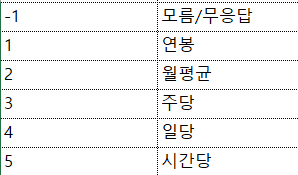


In [ ]:
# 1시간당으로 scale 통일
# 최저임금위원회: https://www.minimumwage.go.kr/minWage/policy/decisionMain.do
# g191d110: 급여 형태 구분 / g191d111: 급여액

year_list = sorted(filtered_df['Y191ear'].unique())  # ['GP10', 'GP11', 'GP12', 'GP13', 'GP14', 'GP15', 'GP16', 'GP17', 'GP19']

min_wage_list = [4110, 4320, 4580, 4860, 5210, 5580, 6030, 6470, 7530, 8350]

min_wage_dict = {
    '0': 4110, '1': 4320, '2': 4580, '3': 4860, '4': 5210,
    '5': 5580, '6': 6030, '7': 6470, '8':7530, '9': 8350
}
# 최저임금의 몇 배인지
def calculate_wage_multiple(row):
    year_last_digit = row['Y191ear'][-1]
    min_wage = min_wage_dict.get(year_last_digit)# 최저임금

    if min_wage is None:
        return None

    if row['g191d110'] == 1:
        return row['g191d111'] * 10000 / (209 * 12) / min_wage  # 연봉
    elif row['g191d110'] == 2:
        return row['g191d111'] * 10000 / 209 / min_wage  # 월평균
    elif row['g191d110'] == 3:
        return row['g191d111'] * 10000 / (209 / 4.345) / min_wage  # 주당
    elif row['g191d110'] == 4:
        return row['g191d111'] * 10000 / 8 / min_wage  # 일당
    elif row['g191d110'] == 5:
        return row['g191d111'] / min_wage  # 시간당
    else:
        return None

job_personal_df['g191d110111'] = job_personal_df.apply(calculate_wage_multiple, axis=1)


job_personal_df.loc[job_personal_df['g191d111'] == -1, 'g191d111'] = 0

In [ ]:
# 결측값 / 모름 값 다 평균으로 처리
avg_g191d110111 = job_personal_df['g191d110111'].mode()[0]

job_personal_df.loc[pd.isna(job_personal_df['g191d110']), 'g191d110111'] = avg_g191d110111
job_personal_df.loc[pd.isna(job_personal_df['g191d111']), 'g191d110111'] = avg_g191d110111

job_personal_df.loc[job_personal_df['g191d111'] == 0.0, 'g191d110111'] = avg_g191d110111
job_personal_df.loc[job_personal_df['g191d110'] == -1.0, 'g191d110111'] = avg_g191d110111

In [ ]:
job_personal_df['g191d110111'] = job_personal_df['g191d110111'].fillna(avg_g191d110111)

In [ ]:
# 원래 컬럼 드랍
job_personal_df.drop(['g191d110', 'g191d111'], axis = 1, inplace = True)

In [ ]:
job_personal_df['g191d110111']

In [ ]:
# g191d245 다른 일자리 제의 경험 여부
job_personal_df['g191d245'] = job_personal_df['g191d245'].apply(lambda x: 1 if x == 1 else 0).astype('category')

In [ ]:
# g191d144 --> 1, 0 처리 D37. <취업자 공통> 첫 직장(일자리) 직장 내 가입여부 1b- 국민연금
job_personal_df['g191d144'] = job_personal_df['g191d144'].apply(lambda x: 1 if x == 1 else 0).astype('category')

In [ ]:
# g191d145 -->  1, 0 처리
job_personal_df['g191d145'] = job_personal_df['g191d145'].apply(lambda x: 1 if x == 1 else 0).astype('category')

In [ ]:
# g191d146 -->  1, 0 처리 D37. <취업자 공통> 첫 직장(일자리) 직장 내 가입여부 3- 건강 보험
job_personal_df['g191d146'] = job_personal_df['g191d146'].apply(lambda x: 1 if x == 1 else 0).astype('category')

In [ ]:
# g191d147 -->  1, 0 처리
job_personal_df['g191d147'] = job_personal_df['g191d147'].apply(lambda x: 1 if x == 1 else 0).astype('category')

In [ ]:
# g191d148 -->  1, 0 처리
job_personal_df['g191d148'] = job_personal_df['g191d148'].apply(lambda x: 1 if x == 1 else 0).astype('category')

In [ ]:
# 중요도 1~5점
# g191k042, g191k043, g191k044, g191k045, g191k046, g191k047, g191k048, g191k049, g191k050, g191k053, g191k055

score_col = ['g191k042', 'g191k043', 'g191k044', 'g191k045', 'g191k046', 'g191k047', 'g191k048', 'g191k049', 'g191k050', 'g191k053', 'g191k055']

job_personal_df['g191d109'][job_personal_df['g191d109']!=-1].mean()

label_encoders = {}
for column in score_col:
  # 최빈값 계산
  col_mode = job_personal_df[column][job_personal_df[column]>=1].mode()[0]
  # nan값은 1로 채우기
  job_personal_df[column] = job_personal_df[column].fillna(col_mode)
  job_personal_df[column][job_personal_df[column]==-1] = col_mode

In [ ]:
# g191d249 범주화
code = 'g191d249'
job_personal_df.loc[(job_personal_df[code] == -3) | (job_personal_df[code] == -1) | (job_personal_df[code] == 14) | (job_personal_df[code] == 15),'g191d249new'] = 1
job_personal_df.loc[(job_personal_df[code] == 1) | (job_personal_df[code] == 2) | (job_personal_df[code] == 3),'g191d249new'] = 2
job_personal_df.loc[(job_personal_df[code] == 4) | (job_personal_df[code] == 5) | (job_personal_df[code] == 6) | (job_personal_df[code] == 10),'g191d249new'] = 3
job_personal_df.loc[(job_personal_df[code] == 7) | (job_personal_df[code] == 8) | (job_personal_df[code] == 9) | (job_personal_df[code] == 11) | (job_personal_df[code] == 12) | (job_personal_df[code] == 13),'g191d249new'] = 4
job_personal_df['g191d249new'].astype('category')

In [ ]:
# 기존 컬럼은 드랍
job_personal_df.drop('g191d249',axis=1, inplace=True)

In [ ]:
job_personal_df

In [ ]:
job_personal_df.isnull().sum()

In [ ]:
# year 컬럼 삭제
job_personal_df.drop('Y191ear',axis=1, inplace=True)

## 3-3. 전처리 (개인환경)


In [ ]:
env_personal_df['g191f071'].unique()

In [ ]:
# g191f071, g191f072 -> 만족도
for column in ['g191f071','g191f072']:
  # 최빈값 계산
  col_mode = env_personal_df[column][env_personal_df[column]>=1].mode()[0]
  # nan값은 1로 채우기
  env_personal_df[column] = env_personal_df[column].fillna(col_mode)
  env_personal_df[column][env_personal_df[column]==-1] = col_mode

In [ ]:
# g191f020 -> 1, 0 처리
env_personal_df['g191f020'][env_personal_df['g191f020'] == 1] = 1
env_personal_df['g191f020'][env_personal_df['g191f020'] == 2] = 0
env_personal_df['g191f020'].astype('category')

In [ ]:
env_personal_df['g191f074'].describe()

In [ ]:
env_personal_df['g191f073'].describe()

In [ ]:
env_personal_df['g191f073'][env_personal_df['g191f073'] == 3] = 4.5
env_personal_df['g191f073'][env_personal_df['g191f073'] == 2] = 4.3
env_personal_df['g191f073'][env_personal_df['g191f073'] == 1] = 4.0

In [ ]:
# g191f073 = 만점, g191f074
# 학점/학점만점 으로 계산해 새로운 컬럼 생성
# 학점만점이 0, -1이면 g191f073074 결과값은 -1로 처리
# 기존 컬럼 drop
env_personal_df.loc[(env_personal_df['g191f073'] == 0) | (env_personal_df['g191f074'] == -1)| (env_personal_df['g191f073'] == -1), 'g191f073074'] = 0
env_personal_df.loc[env_personal_df['g191f073074'].isna(), 'g191f073074'] = env_personal_df['g191f074']/env_personal_df['g191f073']
# 아까 0으로 만든 컬럼에 대해 최빈값 처리
env_personal_df.loc[env_personal_df['g191f073074'] == 0, 'g191f073074'] = env_personal_df['g191f073074'].mode()[0]

env_personal_df.drop(['g191f073', 'g191f074'], axis = 1, inplace = True)

In [ ]:
env_personal_df['g191f073074'].unique()

In [ ]:
# g191f010
# 편입에 해당되면 1로 추가, 나머진 0
env_personal_df['g191f010'] = env_personal_df['g191f010'].apply(lambda x: 1 if x == 2 else 0).astype('category')

In [ ]:
# g191h001 --> 1,0처리
env_personal_df['g191h001'] = env_personal_df['g191h001'].apply(lambda x: 1 if x == 1 else 0).astype('category')

In [ ]:
# g191i001 --> 1,0처리
env_personal_df['g191i001'] = env_personal_df['g191i001'].apply(lambda x: 1 if x == 1 else 0).astype('category')

In [ ]:
# g191j001
env_personal_df['g191j001'] = env_personal_df['g191j001'].apply(lambda x: 1 if x == 1 else 0).astype('category')

In [ ]:
# g191m001
env_personal_df['g191m001'] = env_personal_df['g191m001'].apply(lambda x: 1 if x == 1 else 0).astype('category')

In [ ]:
# g191p001
# g191p001 컬럼에 대해 원핫 인코딩 수행
env_personal_df = pd.get_dummies(env_personal_df, columns=['g191p001'], prefix='g191p001',dtype='category')
env_personal_df.drop(columns=['g191p001_5.0'], inplace=True)

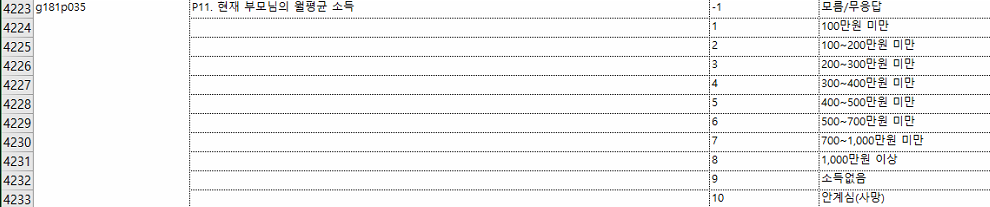

In [ ]:
env_personal_df.loc[env_personal_df['g191p035'] == -1, 'g191p035'] = 300 # 최빈값으로 채우기
env_personal_df.loc[env_personal_df['g191p035'] == 1, 'g191p035'] = 0
env_personal_df.loc[env_personal_df['g191p035'] == 2, 'g191p035'] = 100
env_personal_df.loc[env_personal_df['g191p035'] == 3, 'g191p035'] = 200
env_personal_df.loc[env_personal_df['g191p035'] == 4, 'g191p035'] = 300
env_personal_df.loc[env_personal_df['g191p035'] == 5, 'g191p035'] = 400
env_personal_df.loc[env_personal_df['g191p035'] == 6, 'g191p035'] = 500
env_personal_df.loc[env_personal_df['g191p035'] == 7, 'g191p035'] = 700
env_personal_df.loc[env_personal_df['g191p035'] == 8, 'g191p035'] = 1000
env_personal_df.loc[env_personal_df['g191p035'].isin([9,10]), 'g191p035'] = 0
env_personal_df['g191p035'].fillna(300, inplace=True)

## 3-4.전처리(만족도)

In [ ]:
for column in satisfaction_df.columns:
  # 최빈값 계산
  col_mode = satisfaction_df[column][satisfaction_df[column]>=1].mode()[0]
  # nan값은 1로 채우기
  satisfaction_df[column] = satisfaction_df[column].fillna(col_mode)
  satisfaction_df[column][satisfaction_df[column]==-1] = col_mode

## 3-5. 전처리(직업 특성)

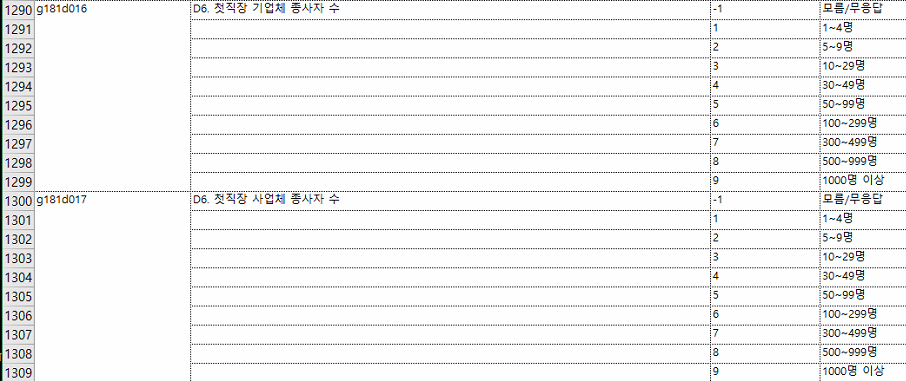

In [ ]:
job_df.columns

In [ ]:
# d022
job_df = pd.get_dummies(job_df, columns=['g191d022'], prefix='g191d022',dtype='category')
job_df.drop(columns=['g191d022_-1.0','g191d022_9.0'], inplace=True)

In [ ]:
# -1값을 최빈값으로 대체
# D29. <취업자 공통> 첫 직장(일자리) 주당 정규 근로일
mode = job_df['g191d106'][job_df['g191d106']!=-1].mode()[0]
job_df['g191d106'][job_df['g191d106']==-1] = mode

In [ ]:
len(job_df['g191d016'][job_df['g191d016'].isin([-1])])

In [ ]:
job_df['g191d016'].unique()

In [ ]:
job_df.loc[job_df['g191d016'] == -1, 'g191d016'] = 10 # 최빈값으로 채우기
job_df.loc[job_df['g191d016'] == 1, 'g191d016'] = 1
job_df.loc[job_df['g191d016'] == 2, 'g191d016'] = 5
job_df.loc[job_df['g191d016'] == 3, 'g191d016'] = 10
job_df.loc[job_df['g191d016'] == 4, 'g191d016'] = 30
job_df.loc[job_df['g191d016'] == 5, 'g191d016'] = 50
job_df.loc[job_df['g191d016'] == 6, 'g191d016'] = 100
job_df.loc[job_df['g191d016'] == 7, 'g191d016'] = 300
job_df.loc[job_df['g191d016'] == 8, 'g191d016'] = 500
job_df.loc[job_df['g191d016'] == 9, 'g191d016'] = 1000

In [ ]:
job_df.loc[job_df['g191d017'] == -1, 'g191d017'] = 10 # 최빈값으로 채우기
job_df.loc[job_df['g191d017'] == 1, 'g191d017'] = 1
job_df.loc[job_df['g191d017'] == 2, 'g191d017'] = 5
job_df.loc[job_df['g191d017'] == 3, 'g191d017'] = 10
job_df.loc[job_df['g191d017'] == 4, 'g191d017'] = 30
job_df.loc[job_df['g191d017'] == 5, 'g191d017'] = 50
job_df.loc[job_df['g191d017'] == 6, 'g191d017'] = 100
job_df.loc[job_df['g191d017'] == 7, 'g191d017'] = 300
job_df.loc[job_df['g191d017'] == 8, 'g191d017'] = 500
job_df.loc[job_df['g191d017'] == 9, 'g191d017'] = 1000

In [ ]:
# g191d018
job_df['g191d018'] = job_df['g191d018'].apply(lambda x: 1 if x == 1 else 0).astype('category')

In [ ]:
# g191d041, g191d042, g191d048, g191d049, g191d051,g191d152
job_df['g191d041'] = job_df['g191d041'].apply(lambda x: 1 if x == 1 else 0).astype('category')
job_df['g191d042'] = job_df['g191d042'].apply(lambda x: 1 if x == 1 else 0).astype('category')
job_df['g191d048'] = job_df['g191d048'].apply(lambda x: 1 if x == 1 else 0).astype('category')
job_df['g191d049'] = job_df['g191d049'].apply(lambda x: 1 if x == 1 else 0).astype('category')
job_df['g191d051'] = job_df['g191d051'].apply(lambda x: 1 if x == 1 else 0).astype('category')
job_df['g191d152'] = job_df['g191d152'].apply(lambda x: 1 if x == 1 else 0).astype('category')

In [ ]:
job_df['g191d020']

In [ ]:
# 원핫 인코딩 수행
job_df = pd.get_dummies(job_df, columns=['g191d020'], prefix='g191d020',dtype='category')
job_df.drop(columns=['g191d020_-1.0'], inplace=True)

## 3-6. 전처리(y값)

In [ ]:
# 값이 1(이직여부o)이면 1, 아니면 F0
filtered_df['g191a297'] = filtered_df['g191a297'].apply(lambda x: 1 if x == 1 else 0)

## 3-6.결측치 처리된 DF 카테고리 4가지 + Y191ear컬럼 + y값(g191a297) concat

In [ ]:
df = pd.concat([env_personal_df, job_personal_df, satisfaction_df, job_df, filtered_df['g191a297'],filtered_df['Y191ear']], axis=1)
df

In [ ]:
df.isnull().sum()

In [ ]:
# 전처리 끝난 데이터 저장
df.to_csv("data/preprocessing_df.csv", index=False, encoding='EUC-KR')

# 4. 4대천왕
- 결측치 처리는 위에서 했으므로 생략

In [29]:
df = pd.read_csv("data/preprocessing_df.csv", encoding='EUC-KR', low_memory=False)

In [30]:
df.columns

Index(['g191f020', 'g191f071', 'g191f072', 'g191f010', 'g191h001', 'g191i001',
       'g191j001', 'g191m001', 'g191p035', 'g191f073074', 'g191p001_1.0',
       'g191p001_2.0', 'g191p001_3.0', 'g191p001_4.0', 'g191d052', 'g191d109',
       'g191d108', 'g191d112', 'g191d144', 'g191d145', 'g191d146', 'g191d147',
       'g191d148', 'g191d245', 'g191j021', 'g191k042', 'g191k053', 'g191k055',
       'g191k043', 'g191k044', 'g191k045', 'g191k046', 'g191k047', 'g191k048',
       'g191k049', 'g191k050', 'g191d110111', 'g191d249new', 'g191d116',
       'g191d117', 'g191d119', 'g191d120', 'g191d121', 'g191d122', 'g191d123',
       'g191d124', 'g191d125', 'g191d126', 'g191d130', 'g191d131', 'g191d132',
       'g191d133', 'g191d016', 'g191d017', 'g191d018', 'g191d041', 'g191d042',
       'g191d048', 'g191d049', 'g191d051', 'g191d106', 'g191d152',
       'g191d022_1.0', 'g191d022_2.0', 'g191d022_3.0', 'g191d022_4.0',
       'g191d022_5.0', 'g191d022_6.0', 'g191d022_7.0', 'g191d022_8.0',
       'g191

In [31]:
number_columns = df.copy().drop(['g191a297','Y191ear'], axis=1).select_dtypes(include=['float', 'int']).columns
number_columns

Index(['g191f020', 'g191f071', 'g191f072', 'g191f010', 'g191h001', 'g191i001',
       'g191j001', 'g191m001', 'g191p035', 'g191f073074', 'g191d052',
       'g191d109', 'g191d108', 'g191d112', 'g191d144', 'g191d145', 'g191d146',
       'g191d147', 'g191d148', 'g191d245', 'g191j021', 'g191k042', 'g191k053',
       'g191k055', 'g191k043', 'g191k044', 'g191k045', 'g191k046', 'g191k047',
       'g191k048', 'g191k049', 'g191k050', 'g191d110111', 'g191d249new',
       'g191d116', 'g191d117', 'g191d119', 'g191d120', 'g191d121', 'g191d122',
       'g191d123', 'g191d124', 'g191d125', 'g191d126', 'g191d130', 'g191d131',
       'g191d132', 'g191d133', 'g191d016', 'g191d017', 'g191d018', 'g191d041',
       'g191d042', 'g191d048', 'g191d049', 'g191d051', 'g191d106', 'g191d152'],
      dtype='object')

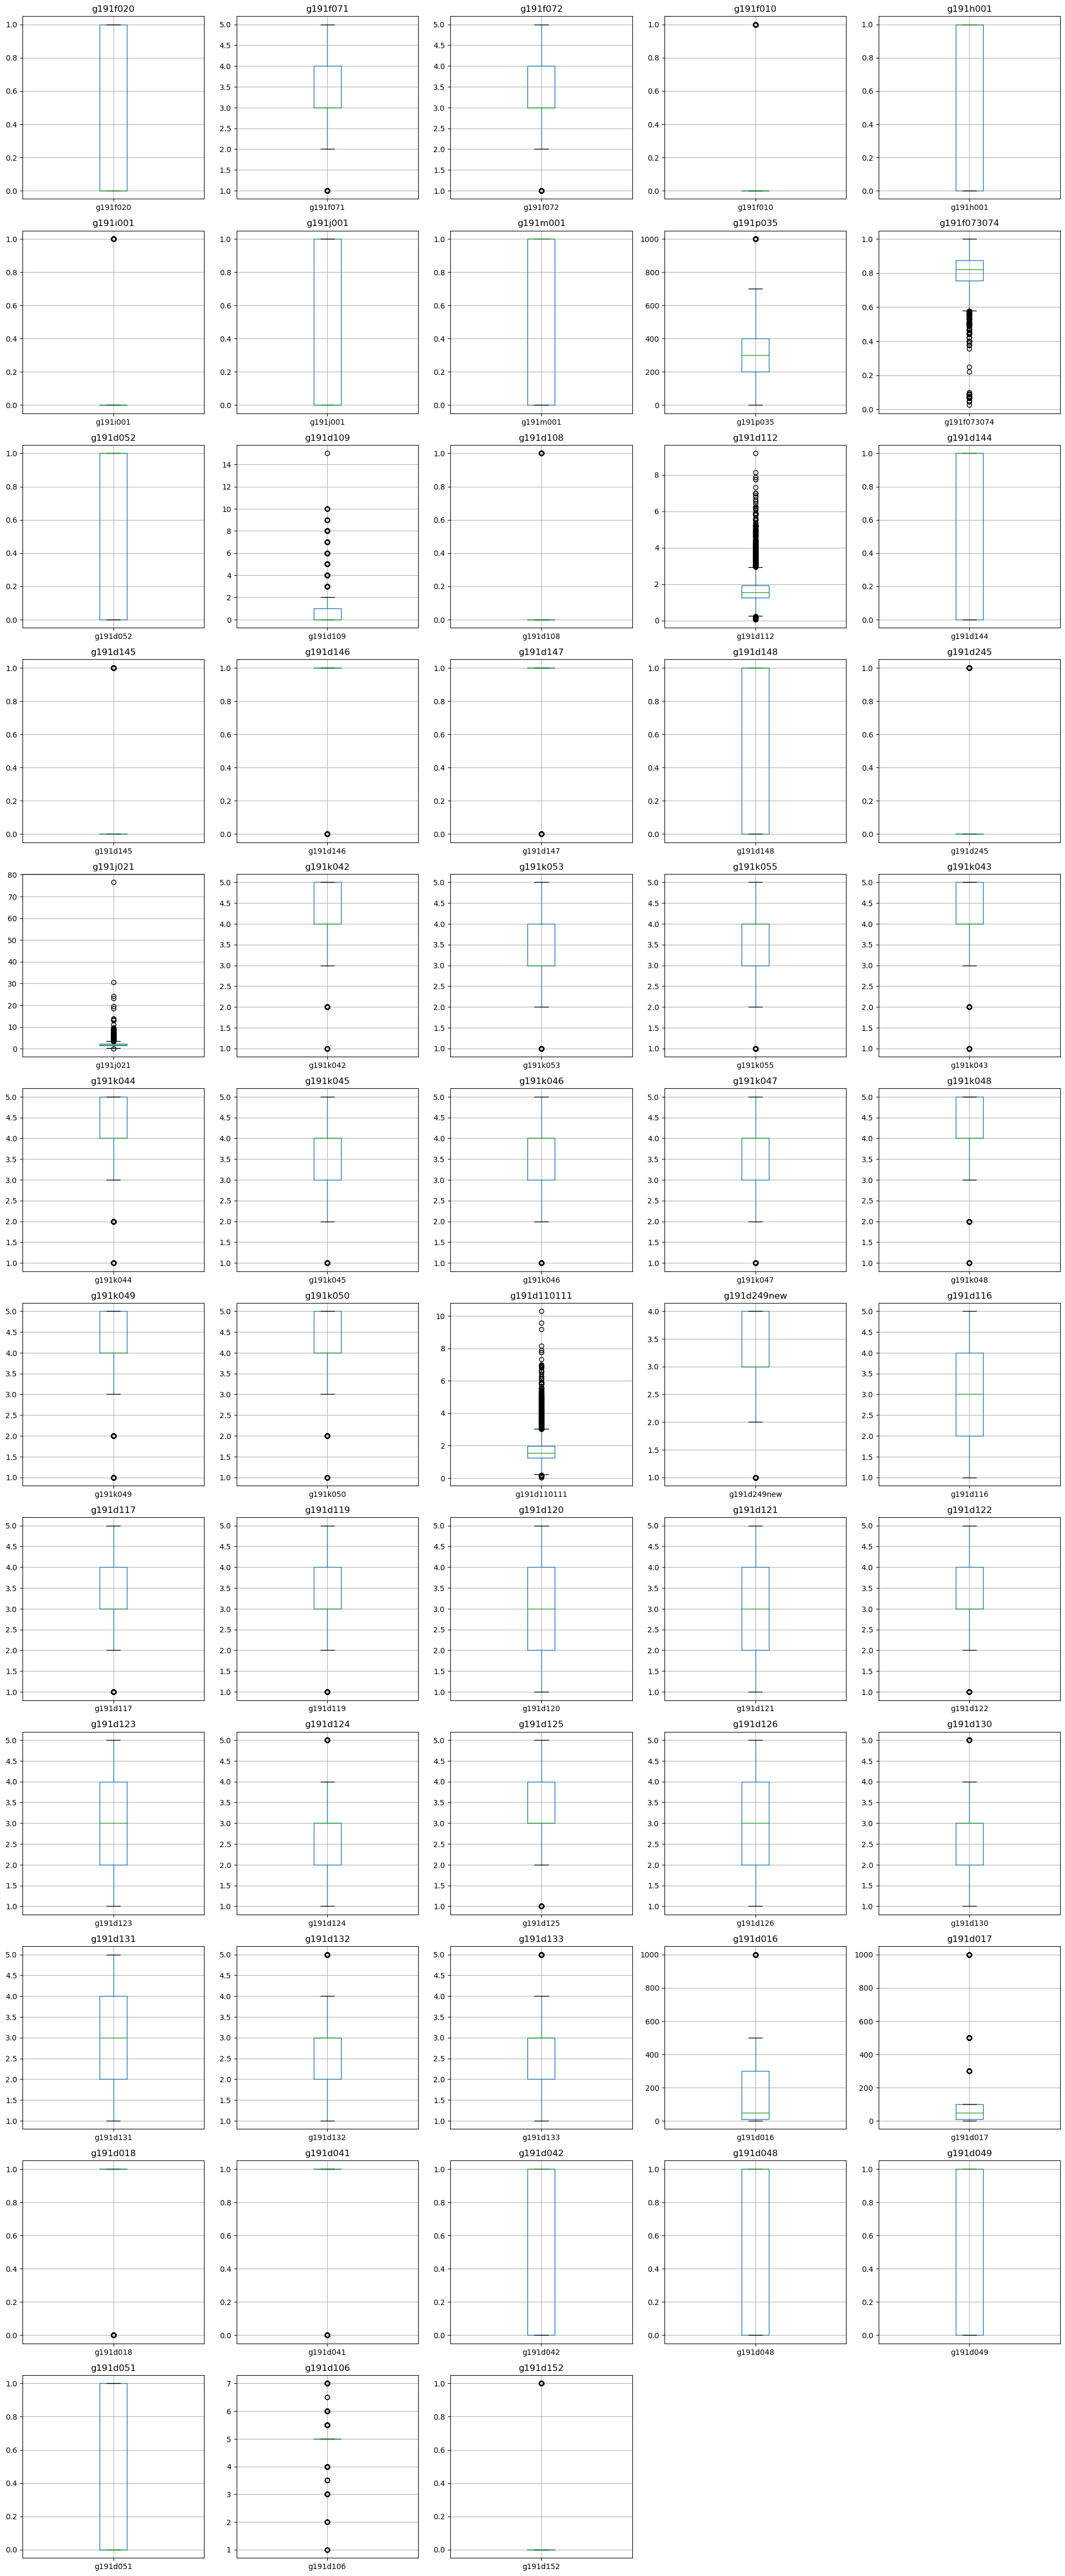

In [32]:
# BoxPlot

# 서브플롯 생성
fig, axes = plt.subplots(nrows=20, ncols=5, figsize=(20, 80))

# 축을 1차원 배열로 변환
axes = axes.flatten()

# 각 컬럼에 대한 박스플롯 그리기
for ax, column in zip(axes, number_columns):
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)

# 나머지 빈 플롯 숨기기
for i in range(len(number_columns), len(axes)):
    fig.delaxes(axes[i])


# 레이아웃 조정
plt.tight_layout()

# 플롯 보여주기
plt.show()

## 4-1. 왜곡도

In [33]:
number_columns = df.copy().drop(['Y191ear','g191a297'], axis=1).select_dtypes(include=['float', 'int']).columns
number_columns

Index(['g191f020', 'g191f071', 'g191f072', 'g191f010', 'g191h001', 'g191i001',
       'g191j001', 'g191m001', 'g191p035', 'g191f073074', 'g191d052',
       'g191d109', 'g191d108', 'g191d112', 'g191d144', 'g191d145', 'g191d146',
       'g191d147', 'g191d148', 'g191d245', 'g191j021', 'g191k042', 'g191k053',
       'g191k055', 'g191k043', 'g191k044', 'g191k045', 'g191k046', 'g191k047',
       'g191k048', 'g191k049', 'g191k050', 'g191d110111', 'g191d249new',
       'g191d116', 'g191d117', 'g191d119', 'g191d120', 'g191d121', 'g191d122',
       'g191d123', 'g191d124', 'g191d125', 'g191d126', 'g191d130', 'g191d131',
       'g191d132', 'g191d133', 'g191d016', 'g191d017', 'g191d018', 'g191d041',
       'g191d042', 'g191d048', 'g191d049', 'g191d051', 'g191d106', 'g191d152'],
      dtype='object')

In [34]:
missing_values = df.columns[df.isnull().any()]
missing_values

Index([], dtype='object')

In [35]:
# 특정 열이 float 타입이면 number_columns 데이터프레임은 int 타입으로 변환
df_copy = df.copy().drop(['Y191ear','g191a297'], axis=1)
for column in number_columns:
    if df_copy[column].dtype == 'float64':
        df_copy[column] = df_copy[column].astype('int')

In [36]:
number_columns = df.copy().drop(['Y191ear','g191a297'], axis=1).select_dtypes(include=['number'])
skew = number_columns.skew(skipna=True)
skew

g191f020        0.125551
g191f071       -0.355099
g191f072       -0.292315
g191f010        4.360782
g191h001       -0.553337
g191i001        2.216347
g191j001        0.153796
g191m001       -0.661753
g191p035        1.154026
g191f073074    -1.312986
g191d052       -1.044894
g191d109        2.442081
g191d108        5.559799
g191d112        1.895956
g191d144       -1.064943
g191d145       11.462153
g191d146       -2.110133
g191d147       -1.990475
g191d148       -0.881085
g191d245        1.297842
g191j021       26.053187
g191k042       -0.656757
g191k053       -0.040293
g191k055       -0.681769
g191k043       -0.724108
g191k044       -0.670418
g191k045       -0.844943
g191k046       -0.611600
g191k047       -0.566413
g191k048       -0.612566
g191k049       -0.661630
g191k050       -0.683939
g191d110111     2.017852
g191d249new    -0.874243
g191d116        0.020308
g191d117       -0.266773
g191d119       -0.289539
g191d120       -0.121567
g191d121       -0.023170
g191d122       -0.355959


In [37]:
rightskew_col = skew[skew > 2].index
rightskew_col

Index(['g191f010', 'g191i001', 'g191d109', 'g191d108', 'g191d145', 'g191j021',
       'g191d110111', 'g191d017', 'g191d152'],
      dtype='object')

In [38]:
leftskew_col = skew[skew < -2].index
leftskew_col

Index(['g191d146', 'g191d018'], dtype='object')

## 4-2. 왜곡도 |2| 이상인 값 변환

In [39]:
# 변환 함수 정의
def rightskew_transform(x):
  p = 0.5
  return (x ** p)

def leftskew_transform(x):
  p = 2
  return (x ** 2)

# 데이터프레임(df)의 각 컬럼에 변환 함수 적용
df[rightskew_col] = rightskew_transform(df[rightskew_col])
df[leftskew_col] = leftskew_transform(df[leftskew_col])

# 결과 확인
df

,g191f020,g191f071,g191f072,g191f010,g191h001,g191i001,g191j001,g191m001,g191p035,g191f073074,...,g191d020_10.0,g191d020_11.0,g191d020_12.0,g191d020_13.0,g191d020_14.0,g191d020_15.0,g191d020_16.0,g191d020_17.0,g191a297,Y191ear
0,1.0,3.0,3.0,0.0,1,0.0,1,1,300.0,0.844444,...,False,False,False,False,False,False,False,False,0,GP19
1,0.0,5.0,3.0,0.0,1,0.0,0,1,200.0,0.888889,...,False,False,False,False,False,False,False,False,0,GP19
2,1.0,5.0,5.0,0.0,1,0.0,0,0,300.0,0.860000,...,False,False,False,False,False,False,True,False,0,GP19
3,1.0,4.0,4.0,0.0,1,0.0,0,1,1000.0,0.844444,...,False,False,False,False,False,False,False,False,1,GP19
4,1.0,3.0,3.0,0.0,0,0.0,0,1,300.0,0.888889,...,False,False,False,False,False,False,False,False,0,GP19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27673,0.0,4.0,3.0,0.0,1,0.0,0,1,200.0,0.711111,...,False,False,False,False,False,False,False,False,0,GP10
27674,0.0,4.0,3.0,0.0,1,0.0,0,1,500.0,0.666667,...,False,False,False,False,False,False,False,False,0,GP10
27675,0.0,4.0,2.0,0.0,1,0.0,1,0,100.0,0.866667,...,False,False,False,False,False,False,False,False,0,GP10
27676,0.0,4.0,3.0,0.0,0,0.0,0,1,200.0,0.888889,...,False,False,False,False,False,False,False,False,0,GP10


## 4-3. 이상치 체크 (제거X)

- g191f074    F15. 졸업 평점 점수
- g191d106	D29. <취업자 공통> 첫 직장(일자리) 주당 정규 근로일
- g191d109	D29. <취업자 공통> 첫 직장(일자리) 월평균 휴일 근로
- g191d108	D29. <취업자 공통> 첫 직장(일자리) 주당 초과 근로시간
- g191d111	D30. <취업자 공통> 첫 직장(일자리) 급여 형태별 근로소득_만원(단, 시간급은 원)
- g191d112	D30. <취업자 공통> 첫 직장(일자리) 월평균 근로소득_만원
- g191j021	J7. 유보임금(희망하는 최소 임금)_연봉_만원

In [40]:
# IQR 기준 이상치 개수 확인
def findOutliers(x, column):

  q1 = x[column].quantile(0.25)
  q3 = x[column].quantile(0.75)
  iqr = q3 - q1
  y = x[(x[column] > (q3 + 1.5*iqr)) | (x[column] < (q1 - 1.5*iqr))]
  return len(y)

for column in number_columns:
  print(column, findOutliers(df, column))

g191f020 0
g191f071 787
g191f072 944
g191f010 1260
g191h001 0
g191i001 3565
g191j001 0
g191m001 0
g191p035 1070
g191f073074 454
g191d052 0
g191d109 870
g191d108 817
g191d112 1178
g191d144 0
g191d145 206
g191d146 3795
g191d147 4077
g191d148 0
g191d245 6306
g191j021 464
g191k042 371
g191k053 853
g191k055 379
g191k043 570
g191k044 385
g191k045 1043
g191k046 334
g191k047 199
g191k048 380
g191k049 429
g191k050 433
g191d110111 814
g191d249new 1107
g191d116 0
g191d117 1629
g191d119 1709
g191d120 0
g191d121 0
g191d122 1988
g191d123 0
g191d124 886
g191d125 1334
g191d126 0
g191d130 807
g191d131 0
g191d132 444
g191d133 426
g191d016 4201
g191d017 2757
g191d018 374
g191d041 5190
g191d042 0
g191d048 0
g191d049 0
g191d051 0
g191d106 6593
g191d152 3537


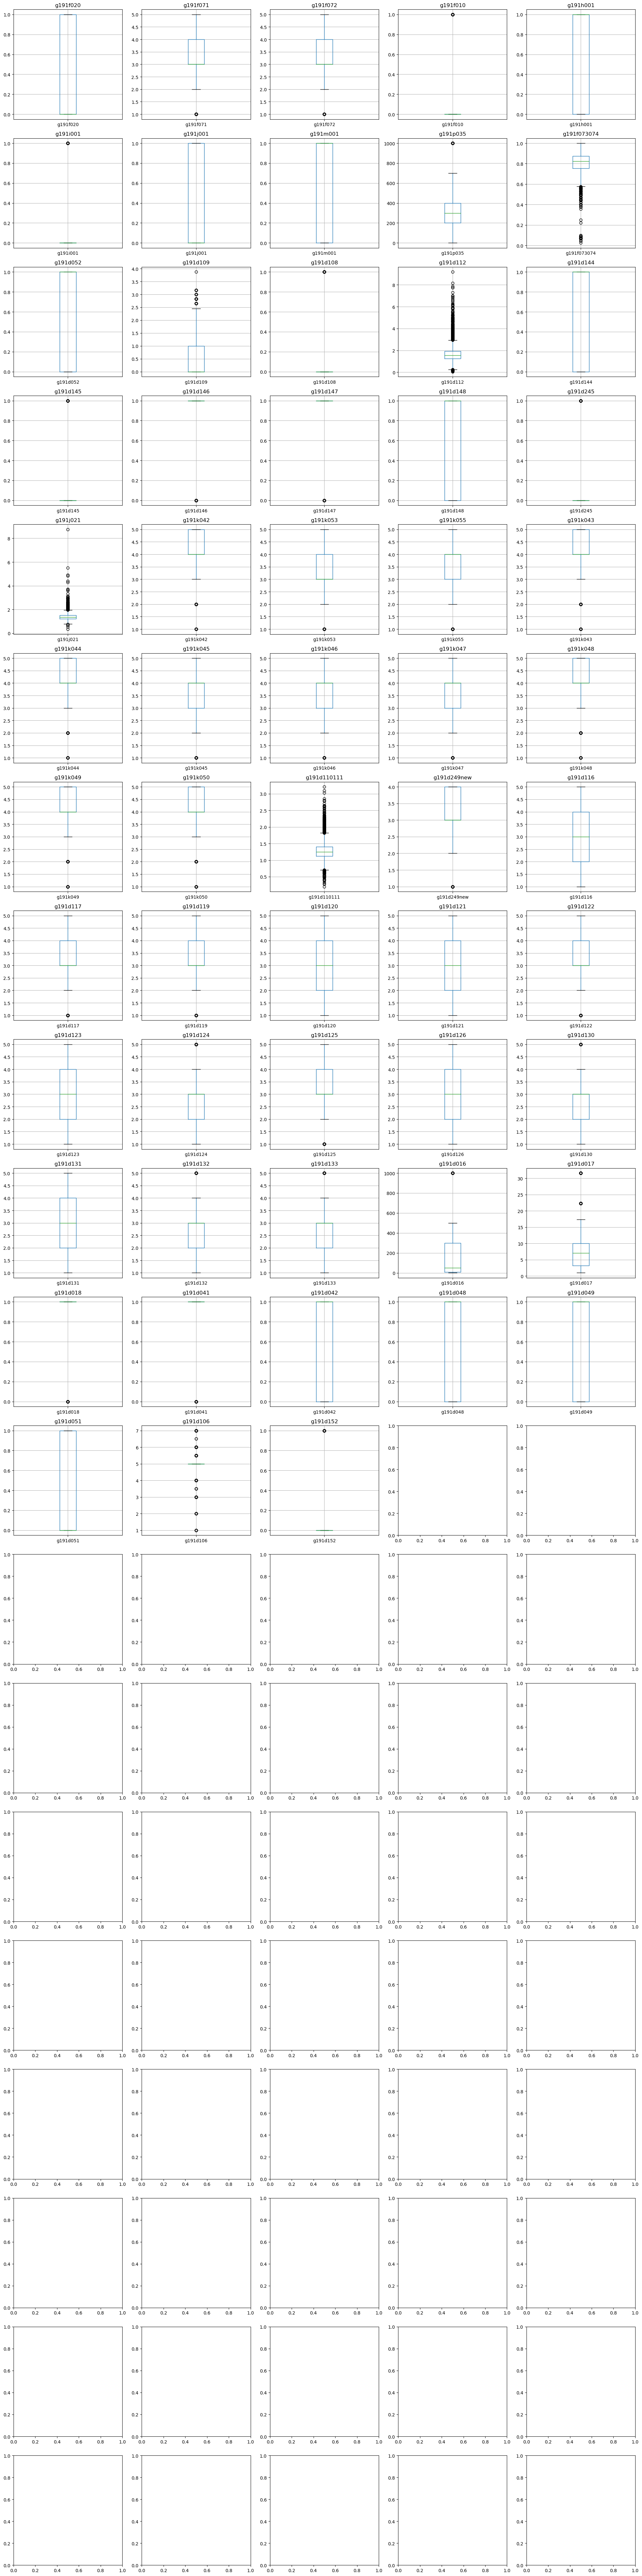

In [41]:
# BoxPlot

# 서브플롯 생성
fig, axes = plt.subplots(nrows=20, ncols=5, figsize=(20, 80))

# 축을 1차원 배열로 변환
axes = axes.flatten()

# 각 컬럼에 대한 박스플롯 그리기
for ax, column in zip(axes, number_columns):
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)

# 나머지 빈 플롯 숨기기
for i in range(len(number_columns), len(axes)):
    fig.delaxes(axes[i])


# 레이아웃 조정
plt.tight_layout()

# 플롯 보여주기
plt.show()

## 4-3. 정규화

In [42]:
df.describe()

,g191f020,g191f071,g191f072,g191f010,g191h001,g191i001,g191j001,g191m001,g191p035,g191f073074,...,g191d017,g191d018,g191d041,g191d042,g191d048,g191d049,g191d051,g191d106,g191d152,g191a297
count,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000,...,27678.000000,27678.000000,27678.000000,27678.00000,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000
mean,0.468675,3.364983,3.233724,0.045524,0.633319,0.128803,0.461666,0.657056,323.513260,0.808713,...,8.223195,0.986487,0.812486,0.68932,0.531866,0.646651,0.464665,5.206861,0.127791,0.147446
std,0.499027,0.882990,0.863001,0.208453,0.481907,0.334987,0.498537,0.474701,214.206023,0.100332,...,7.618573,0.115457,0.390330,0.46278,0.498993,0.478019,0.498759,0.492120,0.333863,0.354556
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,...,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000,0.755556,...,3.162278,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000
50%,0.000000,3.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000,300.000000,0.822222,...,7.071068,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,5.000000,0.000000,0.000000
75%,1.000000,4.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,400.000000,0.875000,...,10.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,5.000000,0.000000,0.000000
max,1.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1000.000000,1.000000,...,31.622777,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000


In [43]:
# 독립변수만 남겨두기
df_indpdt = df.copy().drop(['Y191ear','g191a297'], axis=1)
df_indpdt

,g191f020,g191f071,g191f072,g191f010,g191h001,g191i001,g191j001,g191m001,g191p035,g191f073074,...,g191d020_8.0,g191d020_9.0,g191d020_10.0,g191d020_11.0,g191d020_12.0,g191d020_13.0,g191d020_14.0,g191d020_15.0,g191d020_16.0,g191d020_17.0
0,1.0,3.0,3.0,0.0,1,0.0,1,1,300.0,0.844444,...,False,False,False,False,False,False,False,False,False,False
1,0.0,5.0,3.0,0.0,1,0.0,0,1,200.0,0.888889,...,False,False,False,False,False,False,False,False,False,False
2,1.0,5.0,5.0,0.0,1,0.0,0,0,300.0,0.860000,...,False,False,False,False,False,False,False,False,True,False
3,1.0,4.0,4.0,0.0,1,0.0,0,1,1000.0,0.844444,...,False,False,False,False,False,False,False,False,False,False
4,1.0,3.0,3.0,0.0,0,0.0,0,1,300.0,0.888889,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27673,0.0,4.0,3.0,0.0,1,0.0,0,1,200.0,0.711111,...,False,False,False,False,False,False,False,False,False,False
27674,0.0,4.0,3.0,0.0,1,0.0,0,1,500.0,0.666667,...,True,False,False,False,False,False,False,False,False,False
27675,0.0,4.0,2.0,0.0,1,0.0,1,0,100.0,0.866667,...,True,False,False,False,False,False,False,False,False,False
27676,0.0,4.0,3.0,0.0,0,0.0,0,1,200.0,0.888889,...,False,False,False,False,False,False,False,False,False,False


In [44]:
# 데이터가 정규분포 띄지 않는 경우 standard scaler 보단 minmax scaler 사용
number_columns = df.copy().drop(['Y191ear','g191a297'], axis=1).select_dtypes(include=['float', 'int']).columns

scaler = MinMaxScaler()
scaler.fit_transform(df_indpdt[number_columns])

array([[1.        , 0.5       , 0.5       , ..., 0.        , 0.66666667,
        0.        ],
       [0.        , 1.        , 0.5       , ..., 1.        , 0.66666667,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.66666667,
        0.        ],
       ...,
       [0.        , 0.75      , 0.25      , ..., 0.        , 0.66666667,
        0.        ],
       [0.        , 0.75      , 0.5       , ..., 0.        , 0.83333333,
        0.        ],
       [0.        , 1.        , 1.        , ..., 0.        , 0.66666667,
        0.        ]])

In [45]:
df_indpdt.describe()

,g191f020,g191f071,g191f072,g191f010,g191h001,g191i001,g191j001,g191m001,g191p035,g191f073074,...,g191d016,g191d017,g191d018,g191d041,g191d042,g191d048,g191d049,g191d051,g191d106,g191d152
count,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000,...,27678.000000,27678.000000,27678.000000,27678.000000,27678.00000,27678.000000,27678.000000,27678.000000,27678.000000,27678.000000
mean,0.468675,3.364983,3.233724,0.045524,0.633319,0.128803,0.461666,0.657056,323.513260,0.808713,...,221.194089,8.223195,0.986487,0.812486,0.68932,0.531866,0.646651,0.464665,5.206861,0.127791
std,0.499027,0.882990,0.863001,0.208453,0.481907,0.334987,0.498537,0.474701,214.206023,0.100332,...,349.602241,7.618573,0.115457,0.390330,0.46278,0.498993,0.478019,0.498759,0.492120,0.333863
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,...,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000,0.755556,...,10.000000,3.162278,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,0.000000,3.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000,300.000000,0.822222,...,50.000000,7.071068,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,5.000000,0.000000
75%,1.000000,4.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,400.000000,0.875000,...,300.000000,10.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,5.000000,0.000000
max,1.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1000.000000,1.000000,...,1000.000000,31.622777,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,7.000000,1.000000


In [46]:
df = pd.concat([df_indpdt, df[['Y191ear','g191a297']]], axis=1)

In [47]:
# save
df.to_csv("data/clean_df.csv", index=False, encoding='EUC-KR')

# 5. 상관관계
- +-0.8 이상인 관계는 두 컬럼 중 하나만 남기기


In [48]:
# read clean df
clean_df = pd.read_csv('data/clean_df.csv', encoding='EUC-KR', low_memory=False)

In [49]:
clean_df.columns

Index(['g191f020', 'g191f071', 'g191f072', 'g191f010', 'g191h001', 'g191i001',
       'g191j001', 'g191m001', 'g191p035', 'g191f073074', 'g191p001_1.0',
       'g191p001_2.0', 'g191p001_3.0', 'g191p001_4.0', 'g191d052', 'g191d109',
       'g191d108', 'g191d112', 'g191d144', 'g191d145', 'g191d146', 'g191d147',
       'g191d148', 'g191d245', 'g191j021', 'g191k042', 'g191k053', 'g191k055',
       'g191k043', 'g191k044', 'g191k045', 'g191k046', 'g191k047', 'g191k048',
       'g191k049', 'g191k050', 'g191d110111', 'g191d249new', 'g191d116',
       'g191d117', 'g191d119', 'g191d120', 'g191d121', 'g191d122', 'g191d123',
       'g191d124', 'g191d125', 'g191d126', 'g191d130', 'g191d131', 'g191d132',
       'g191d133', 'g191d016', 'g191d017', 'g191d018', 'g191d041', 'g191d042',
       'g191d048', 'g191d049', 'g191d051', 'g191d106', 'g191d152',
       'g191d022_1.0', 'g191d022_2.0', 'g191d022_3.0', 'g191d022_4.0',
       'g191d022_5.0', 'g191d022_6.0', 'g191d022_7.0', 'g191d022_8.0',
       'g191

In [50]:
clean_df_indpdt = clean_df.copy().drop(['Y191ear','g191a297'], axis=1)
clean_df_indpdt

,g191f020,g191f071,g191f072,g191f010,g191h001,g191i001,g191j001,g191m001,g191p035,g191f073074,...,g191d020_8.0,g191d020_9.0,g191d020_10.0,g191d020_11.0,g191d020_12.0,g191d020_13.0,g191d020_14.0,g191d020_15.0,g191d020_16.0,g191d020_17.0
0,1.0,3.0,3.0,0.0,1,0.0,1,1,300.0,0.844444,...,False,False,False,False,False,False,False,False,False,False
1,0.0,5.0,3.0,0.0,1,0.0,0,1,200.0,0.888889,...,False,False,False,False,False,False,False,False,False,False
2,1.0,5.0,5.0,0.0,1,0.0,0,0,300.0,0.860000,...,False,False,False,False,False,False,False,False,True,False
3,1.0,4.0,4.0,0.0,1,0.0,0,1,1000.0,0.844444,...,False,False,False,False,False,False,False,False,False,False
4,1.0,3.0,3.0,0.0,0,0.0,0,1,300.0,0.888889,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27673,0.0,4.0,3.0,0.0,1,0.0,0,1,200.0,0.711111,...,False,False,False,False,False,False,False,False,False,False
27674,0.0,4.0,3.0,0.0,1,0.0,0,1,500.0,0.666667,...,True,False,False,False,False,False,False,False,False,False
27675,0.0,4.0,2.0,0.0,1,0.0,1,0,100.0,0.866667,...,True,False,False,False,False,False,False,False,False,False
27676,0.0,4.0,3.0,0.0,0,0.0,0,1,200.0,0.888889,...,False,False,False,False,False,False,False,False,False,False


In [51]:
# 상관관계 분석
clean_df_indpdt.corr()

,g191f020,g191f071,g191f072,g191f010,g191h001,g191i001,g191j001,g191m001,g191p035,g191f073074,...,g191d020_8.0,g191d020_9.0,g191d020_10.0,g191d020_11.0,g191d020_12.0,g191d020_13.0,g191d020_14.0,g191d020_15.0,g191d020_16.0,g191d020_17.0
g191f020,1.000000,0.314087,0.195743,0.027255,-0.071578,-0.022873,0.032425,-0.006609,0.007127,0.084493,...,0.005897,0.003169,-0.004267,0.013395,0.012090,-0.000390,-0.012231,-0.005425,0.009166,0.004553
g191f071,0.314087,1.000000,0.634027,0.032806,0.001122,0.023677,0.084068,0.024258,0.020720,0.077126,...,0.011002,-0.004901,0.002733,0.003726,0.015187,0.007648,-0.003120,-0.000811,-0.004647,0.004120
g191f072,0.195743,0.634027,1.000000,0.044288,-0.010941,0.045590,0.050428,0.016096,0.013993,0.034297,...,-0.001956,-0.004083,0.006565,0.014692,0.021240,0.014279,-0.002101,0.008793,0.005074,0.003068
g191f010,0.027255,0.032806,0.044288,1.000000,-0.073007,-0.006877,0.007753,0.028520,-0.007790,-0.013527,...,0.012519,0.001094,0.005973,-0.010096,-0.001514,0.000812,-0.004118,-0.010975,-0.004230,-0.003570
g191h001,-0.071578,0.001122,-0.010941,-0.073007,1.000000,0.055555,0.139630,0.062618,-0.015038,-0.031630,...,-0.001890,-0.015640,-0.015150,-0.014592,-0.004405,-0.020598,-0.031345,-0.030787,0.008897,0.000309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
g191d020_13.0,-0.000390,0.007648,0.014279,0.000812,-0.020598,-0.024214,-0.010523,0.035090,-0.022027,0.009208,...,-0.064161,-0.018789,-0.023188,-0.025871,-0.021669,1.000000,-0.028426,-0.032148,-0.015208,-0.006864
g191d020_14.0,-0.012231,-0.003120,-0.002101,-0.004118,-0.031345,-0.016300,-0.007160,0.028100,-0.031418,0.009118,...,-0.092533,-0.027097,-0.033442,-0.037311,-0.031251,-0.028426,1.000000,-0.046364,-0.021933,-0.009899
g191d020_15.0,-0.005425,-0.000811,0.008793,-0.010975,-0.030787,0.004650,-0.026859,0.012915,-0.015291,-0.009877,...,-0.104650,-0.030645,-0.037821,-0.042197,-0.035343,-0.032148,-0.046364,1.000000,-0.024805,-0.011195
g191d020_16.0,0.009166,-0.004647,0.005074,-0.004230,0.008897,-0.004378,-0.001486,0.010013,-0.012836,0.036233,...,-0.049504,-0.014497,-0.017891,-0.019961,-0.016719,-0.015208,-0.021933,-0.024805,1.000000,-0.005296


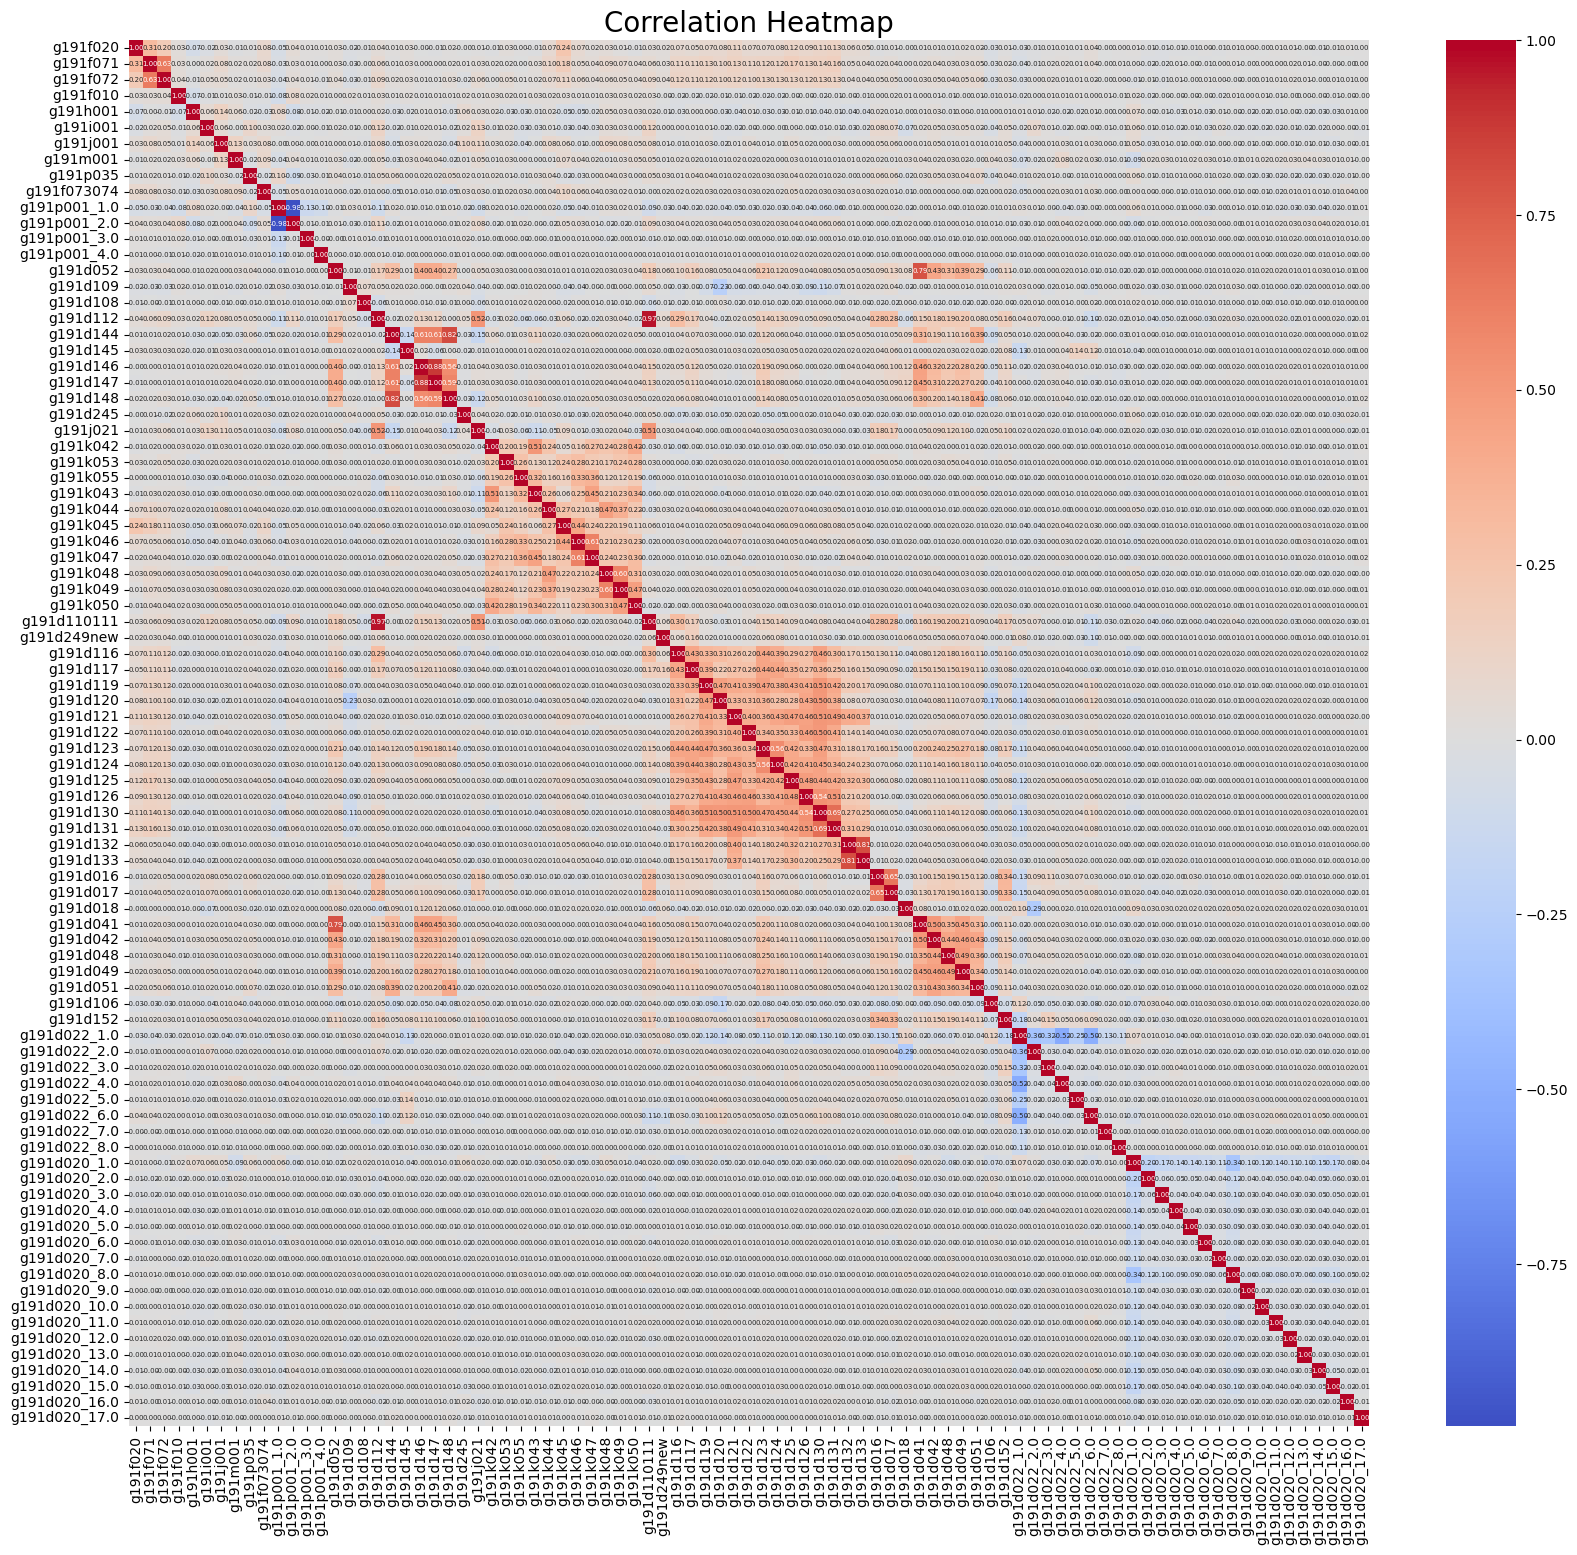

In [52]:
# 상관 관계 행렬 계산
corr_matrix = clean_df_indpdt.corr()

# 히트맵 그리기
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            annot_kws={"size": 5}, fmt=".2f")  # 텍스트 크기를 작게 하고 소수점 둘째자리까지 표시
plt.title('Correlation Heatmap', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [53]:
# 상관 관계 행렬 계산
corr_matrix = clean_df_indpdt.corr()

# 상관 관계가 +-0.8 이상인 컬럼 쌍 찾기
high_corr_pairs = []
threshold = 0.8
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# 결과 출력
high_corr_pairs_df = pd.DataFrame(high_corr_pairs, columns=['Column 1', 'Column 2', 'Correlation'])
print(high_corr_pairs_df)

       Column 1      Column 2  Correlation
0  g191p001_1.0  g191p001_2.0    -0.982066
1      g191d112   g191d110111     0.968240
2      g191d144      g191d148     0.817262
3      g191d146      g191d147     0.881728
4      g191d132      g191d133     0.813227


In [54]:
# high_corr_pairs_df['Column 2']에 해당되는 컬럼 삭제
high_col2 = list(high_corr_pairs_df['Column 2'])
clean_done_df = clean_df.drop(columns=high_col2, axis=1)

In [55]:
len(clean_done_df.columns)

84

In [56]:
# clean_done_df 저장
clean_done_df.to_csv("data/clean_done_df.csv", index=False, encoding='EUC-KR')